## 4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기

### 1. Augmentation을 적용한 데이터셋 만들기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 필요한 라이브러리를 불러오고 GPU환경을 확인합니다.

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

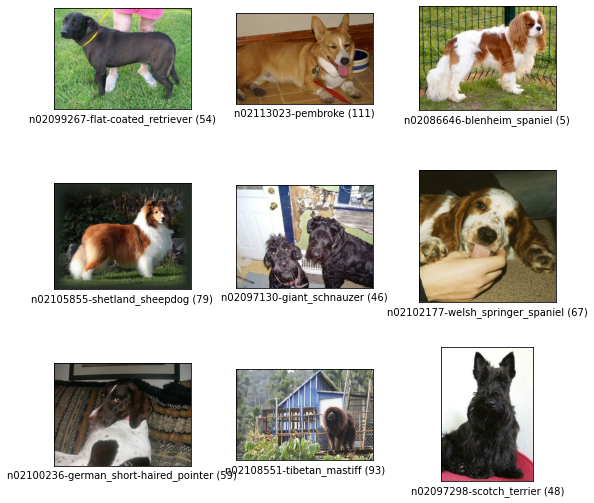

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

#### 사용할 데이터셋 stanford_dogs 를 불러와 이미지를 확인해 보니 귀여운 강아지들 이네요.

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

#### 전처리 함수를 만들고, random augmentation들 중에서 random_flip_left_right()과 random_brightness()를 활용합니다.

In [8]:
# make random augment function
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image, label

#### 위에서는 미리 구현된 random augmentation을 적용하도록 augment() 함수를 작성했다면 이번에는 tf.image의 다양한 함수들을 이용해서 직접 다양한 augmentation 기법을 랜덤하게 적용하는 augment2() 함수를 작성합니다.

In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어 줍니다.

In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

#### augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고 검증하는 과정은 프로젝트에서 할것이므로 생략하겠습니다.

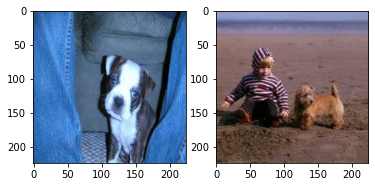

In [12]:
# 데이터셋에서 이미지 2개를 가져오기. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

#### 조금 더 복잡한 augmentation 방법을 적용해 보겠습니다. 우선 이미지 두개를 불러옵니다,

In [13]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width  = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x - width //  2)
    ya = tf.math.maximum(0, y - height // 2)
    xb = tf.math.minimum(image_size_x, x + width // 2)
    yb = tf.math.minimum(image_size_y, y + width // 2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(6, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(198, shape=(), dtype=int32) tf.Tensor(173, shape=(), dtype=int32)


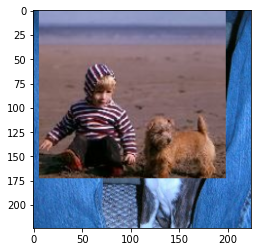

In [14]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya : yb, 0  : xa, :]
    two = image_b[ya : yb, xa : xb, :]
    three = image_a[ya : yb, xb : image_size_x, :]
    middle = tf.concat([one, two, three], axis = 1)
    top = image_a[0 : ya, :, :]
    bottom = image_a[yb : image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis = 0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

#### 바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 b에서 바운딩 박스의 위치를 결정하는 함수와  합치는 함수를 구현해 봅니다.

In [15]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes = 120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb - xa) * (yb - ya)
    total_area = image_size_x * image_size_y
    a = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1 - a) * label_a + a * label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.6619898, 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.3380102, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [16]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### CutMix에서는 면적에 비례해서 라벨을 섞어주고, 위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현해 봅니다.

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.6619898
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.3380102 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0

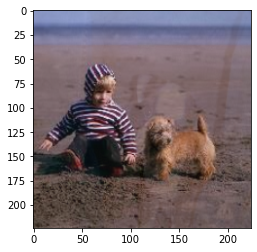

In [17]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [18]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### 위의 함수를 활용하여 배치 단위의 cutmix() 함수와 mixup() 함수를 구현해 봅니다.

In [19]:
def onehot(image, label, prob = 1.0, batch_size = 16, img_size = 224, num_classes = 120):
    imgs = []
    labels = []

    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    
    return onehot_imgs, labels

In [20]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup = False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup, 
            num_parallel_calls = 2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

#### 앞에서 구현한것 처럼 일반적이 전처리 과정을 적용한 데이터셋을 만들어줍니다.

### 2. 모델 만들기

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [22]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [23]:
#num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [24]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [25]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [26]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### ResNet-50모델을 사용해 no augmentation, basic augmentation,  Cutmix,  Mixup 을 적용한 데이터들을 학습할 수 있도록 모델을 설계합니다.

### 3. 모델 훈련하기

#### 

In [27]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [28]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 145s 148ms/step - loss: 3.2226 - accuracy: 0.2805 - val_loss: 3.3276 - val_accuracy: 0.2190
Epoch 2/20
750/750 [==============================] - 112s 149ms/step - loss: 0.9612 - accuracy: 0.7360 - val_loss: 1.1127 - val_accuracy: 0.6748
Epoch 3/20
750/750 [==============================] - 112s 150ms/step - loss: 0.3738 - accuracy: 0.9060 - val_loss: 0.9896 - val_accuracy: 0.7092
Epoch 4/20
750/750 [==============================] - 112s 149ms/step - loss: 0.1390 - accuracy: 0.9746 - val_loss: 0.9685 - val_accuracy: 0.7229
Epoch 5/20
750/750 [==============================] - 113s 151ms/step - loss: 0.0636 - accuracy: 0.9939 - val_loss: 0.9373 - val_accuracy: 0.7348
Epoch 6/20
750/750 [==============================] - 114s 152ms/step - loss: 0.0321 - accuracy: 0.9979 - val_loss: 0.9154 - val_accuracy: 0.7462
Epoch 7/20
750/750 [==============================] - 115s 153ms/step - loss: 0.0167 - accuracy: 0.9991 - val_loss: 0.9163 -

In [29]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 114s 147ms/step - loss: 3.1989 - accuracy: 0.2768 - val_loss: 2.8845 - val_accuracy: 0.2843
Epoch 2/20
750/750 [==============================] - 110s 147ms/step - loss: 1.0919 - accuracy: 0.6917 - val_loss: 1.3054 - val_accuracy: 0.6272
Epoch 3/20
750/750 [==============================] - 110s 147ms/step - loss: 0.6022 - accuracy: 0.8333 - val_loss: 1.1276 - val_accuracy: 0.6764
Epoch 4/20
750/750 [==============================] - 110s 147ms/step - loss: 0.3332 - accuracy: 0.9130 - val_loss: 1.0273 - val_accuracy: 0.7062
Epoch 5/20
750/750 [==============================] - 110s 147ms/step - loss: 0.2083 - accuracy: 0.9523 - val_loss: 1.0297 - val_accuracy: 0.7069
Epoch 6/20
750/750 [==============================] - 110s 147ms/step - loss: 0.1253 - accuracy: 0.9761 - val_loss: 1.0031 - val_accuracy: 0.7167
Epoch 7/20
750/750 [==============================] - 110s 147ms/step - loss: 0.0713 - accuracy: 0.9892 - val_loss: 1.0586 -

In [30]:
history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 116s 149ms/step - loss: 4.3320 - accuracy: 0.1167 - val_loss: 3.8215 - val_accuracy: 0.1406
Epoch 2/20
750/750 [==============================] - 111s 148ms/step - loss: 3.0599 - accuracy: 0.4006 - val_loss: 1.9566 - val_accuracy: 0.4749
Epoch 3/20
750/750 [==============================] - 111s 148ms/step - loss: 2.6889 - accuracy: 0.5220 - val_loss: 1.2807 - val_accuracy: 0.6500
Epoch 4/20
750/750 [==============================] - 111s 148ms/step - loss: 2.4908 - accuracy: 0.5782 - val_loss: 1.3277 - val_accuracy: 0.6403
Epoch 5/20
750/750 [==============================] - 111s 148ms/step - loss: 2.3707 - accuracy: 0.6144 - val_loss: 1.2568 - val_accuracy: 0.6573
Epoch 6/20
750/750 [==============================] - 111s 148ms/step - loss: 2.1999 - accuracy: 0.6698 - val_loss: 1.2841 - val_accuracy: 0.6560
Epoch 7/20
750/750 [==============================] - 111s 148ms/step - loss: 2.1499 - accuracy: 0.6893 - val_loss: 1.3172 -

In [31]:
history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 117s 150ms/step - loss: 4.2593 - accuracy: 0.1312 - val_loss: 3.6536 - val_accuracy: 0.1725
Epoch 2/20
750/750 [==============================] - 113s 150ms/step - loss: 2.9790 - accuracy: 0.4327 - val_loss: 1.5982 - val_accuracy: 0.5564
Epoch 3/20
750/750 [==============================] - 113s 151ms/step - loss: 2.6157 - accuracy: 0.5574 - val_loss: 1.5118 - val_accuracy: 0.5933
Epoch 4/20
750/750 [==============================] - 114s 152ms/step - loss: 2.4472 - accuracy: 0.6358 - val_loss: 1.2643 - val_accuracy: 0.6510
Epoch 5/20
750/750 [==============================] - 114s 152ms/step - loss: 2.3343 - accuracy: 0.6789 - val_loss: 1.3073 - val_accuracy: 0.6427
Epoch 6/20
750/750 [==============================] - 114s 152ms/step - loss: 2.2203 - accuracy: 0.7290 - val_loss: 1.2137 - val_accuracy: 0.6671
Epoch 7/20
750/750 [==============================] - 114s 152ms/step - loss: 2.1550 - accuracy: 0.7445 - val_loss: 1.4042 -

#### augmentation 적용 효과를 명확히 검증하기 위해서 각각 20 EPOC각씨 학습을 시켰습니다.

### 4. 훈련 과정 시각화하기

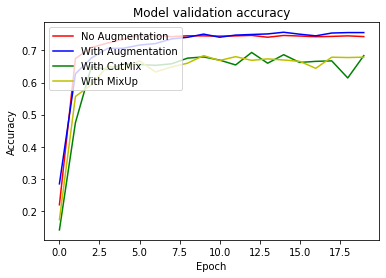

In [34]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'g')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp'], loc = 'upper left')
plt.show()

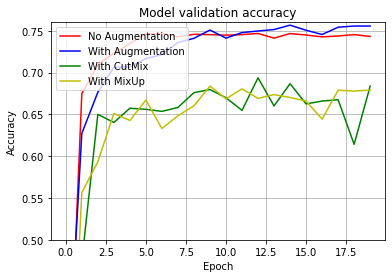

In [38]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'g')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp'], loc = 'upper left')
plt.grid(True)
plt.ylim(0.50, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()

#### 훈련 과정을 시각화 해 보았습니다

### 5. Augmentation에 의한 모델 성능 비교

#### 네가지 데이터중 basic한 augmentation 적용한 모델이 성능이 제일 좋게 나왔고 그다음이 augmentation을 적용하지 않은 데이터, 그리고 성왜이 높을 것이라고 예상했던 Cutmix, Mixup는 내 예상을 깨고 성능이 낮았다. 아무래도 원본 데이터가 심하게 왜곡되어서 진행되었기 때문에 제대로 학습이 안된것은 아닐까 짐작해본다.

## 총평

### 첫번째 과제로 너무 힘이 들어서인지 오히려 Augmentation과제는 처음부터 차근차근 따라서 해보니 많이 어렵지는 않았다 그리고 오히려 여러가지Augmentation기법을 습득할수 있어서 좋았다. 매일 과제가 이정도만 되도 의욕이 생길것 같다.